In [1]:
from corsikaio.subblocks import event_end_types
from sqlalchemy import values
%load_ext autoreload


from ctapipe.io import EventSource, EventSeeker
import sys
 
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline
import sys
from scipy.stats import norm
from traitlets.config.loader import Config 
from ctapipe import utils

# ctapipe modules
from ctapipe.visualization import CameraDisplay
from ctapipe.image.extractor import *

from ctapipe.io.hdf5tableio import HDF5TableWriter, HDF5TableReader
from ctapipe.instrument import TelescopeDescription, CameraGeometry
from ctapipe.coordinates import EngineeringCameraFrame

camera = CameraGeometry.from_name("NectarCam-003").transform_to(EngineeringCameraFrame())



In [2]:
%env NECTARCAMDATA = /tmp/amikhno/scratch
import os

tmpdir = f"/tmp/{os.environ['USER']}/scratch/runs"
if not os.path.isdir(tmpdir):
    print(f"{tmpdir} does not exist yet, I will create it for you")
    os.makedirs(tmpdir)

env: NECTARCAMDATA=/tmp/amikhno/scratch


In [3]:
import DIRAC
import ZEO
from astropy.io import fits
from DIRAC.Interfaces.API.Dirac import Dirac
from glob import glob
from nectarchain.dqm.db_utils import DQMDB

cmap = "gnuplot2"

run = 5922  # 22/05

from nectarchain.data.management import DataManagement

dm = DataManagement()
_, filelist = dm.findrun(run)

print(filelist)

[PosixPath('/tmp/amikhno/scratch/runs/NectarCAM.Run5922.0000.fits.fz'), PosixPath('/tmp/amikhno/scratch/runs/NectarCAM.Run5922.0001.fits.fz'), PosixPath('/tmp/amikhno/scratch/runs/NectarCAM.Run5922.0002.fits.fz'), PosixPath('/tmp/amikhno/scratch/runs/NectarCAM.Run5922.0003.fits.fz'), PosixPath('/tmp/amikhno/scratch/runs/NectarCAM.Run5922.0004.fits.fz'), PosixPath('/tmp/amikhno/scratch/runs/NectarCAM.Run5922.0005.fits.fz'), PosixPath('/tmp/amikhno/scratch/runs/NectarCAM.Run5922.0006.fits.fz'), PosixPath('/tmp/amikhno/scratch/runs/NectarCAM.Run5922.0007.fits.fz')]


In [4]:
pwd = glob(f"{tmpdir}/NectarCAM.*.fits.fz")
print(pwd)

['/tmp/amikhno/scratch/runs/NectarCAM.Run5922.0007.fits.fz', '/tmp/amikhno/scratch/runs/NectarCAM.Run5922.0003.fits.fz', '/tmp/amikhno/scratch/runs/NectarCAM.Run5922.0000.fits.fz', '/tmp/amikhno/scratch/runs/NectarCAM.Run5922.0006.fits.fz', '/tmp/amikhno/scratch/runs/NectarCAM.Run5922.0001.fits.fz', '/tmp/amikhno/scratch/runs/NectarCAM.Run5922.0002.fits.fz', '/tmp/amikhno/scratch/runs/NectarCAM.Run5922.0005.fits.fz', '/tmp/amikhno/scratch/runs/NectarCAM.Run5922.0004.fits.fz']


In [6]:
from ctapipe.containers import EventType

source = EventSource.from_url(input_url=filelist[0])

2025-01-27 09:27:01,114 ctapipe.io.hdf5tableio.HDF5TableReader WARN Table /tel_0/calibration is missing column time_correction for field time_correction of container <class 'ctapipe.containers.WaveformCalibrationContainer'>. It will be skipped.
2025-01-27 09:27:01,115 ctapipe.io.hdf5tableio.HDF5TableReader WARN Table /tel_0/calibration is missing column n_pe for field n_pe of container <class 'ctapipe.containers.WaveformCalibrationContainer'>. It will be skipped.
2025-01-27 09:27:01,120 ctapipe.io.hdf5tableio.HDF5TableReader WARN Table /tel_0/flatfield is missing column charge_mean for field charge_mean of container <class 'ctapipe.containers.FlatFieldContainer'>. It will be skipped.
2025-01-27 09:27:01,121 ctapipe.io.hdf5tableio.HDF5TableReader WARN Table /tel_0/flatfield is missing column charge_median for field charge_median of container <class 'ctapipe.containers.FlatFieldContainer'>. It will be skipped.
2025-01-27 09:27:01,121 ctapipe.io.hdf5tableio.HDF5TableReader WARN Table /tel

In [386]:
for event in source:
    print(event.index.event_id, event.trigger.event_type, event.trigger.time)

6 EventType.FLATFIELD 1736260866.1858552
10 EventType.FLATFIELD 1736260866.1898553
14 EventType.FLATFIELD 1736260866.1938555
18 EventType.FLATFIELD 1736260866.1978557
22 EventType.FLATFIELD 1736260866.2018561
26 EventType.FLATFIELD 1736260866.2058563
30 EventType.FLATFIELD 1736260866.2098565
34 EventType.FLATFIELD 1736260866.2138567
38 EventType.FLATFIELD 1736260866.217857
42 EventType.FLATFIELD 1736260866.221857
46 EventType.FLATFIELD 1736260866.2258573
50 EventType.FLATFIELD 1736260866.2298574
54 EventType.FLATFIELD 1736260866.2338576
58 EventType.FLATFIELD 1736260866.237858
62 EventType.FLATFIELD 1736260866.2418582
66 EventType.FLATFIELD 1736260866.2458584
70 EventType.FLATFIELD 1736260866.2498586
74 EventType.FLATFIELD 1736260866.2538588
78 EventType.FLATFIELD 1736260866.257859
82 EventType.FLATFIELD 1736260866.2618592
86 EventType.FLATFIELD 1736260866.2658594
90 EventType.FLATFIELD 1736260866.2698598
94 EventType.FLATFIELD 1736260866.27386
98 EventType.FLATFIELD 1736260866.2778602

In [1]:
?event

Object `event` not found.


In [7]:
for event in source:
    # select only flatfield events
    print(f"read event id: {event.index.event_id }, trigger {event.trigger.event_type}")
    if event.trigger.event_type == EventType.FLATFIELD:
        break
    # elif event.trigger.event_type == SKY_PEDESTAL or  eevent.trigger.event_type == SUBARRAY:
    #    break

print(f"read event id: {event.index.event_id }, trigger {event.trigger.event_type}")

read event id: 2, trigger EventType.FLATFIELD
read event id: 2, trigger EventType.FLATFIELD


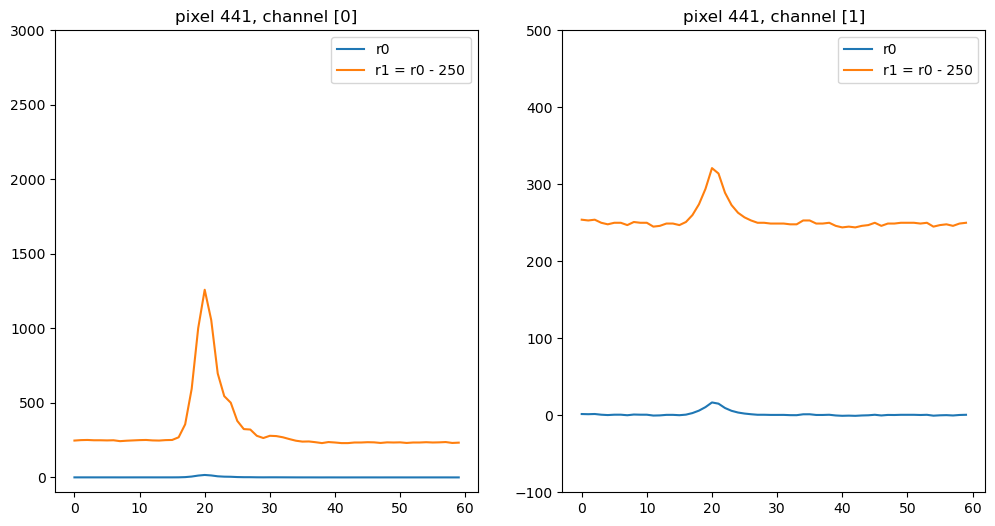

In [10]:
pix = 441

fig = plt.figure(300, figsize=(12, 6))
label = "r0"
label1 = "r1 = r0 - 250"
chan = 0
plt.subplot(1, 2, 1)
plt.plot(event.r1.tel[0].waveform[chan, pix], label=label)
plt.plot(event.r0.tel[0].waveform[chan, pix], label=label1)
plt.title(f"pixel {pix}, channel {[chan]}")
plt.ylim(-100, 3000)
plt.legend()
chan = 1
plt.subplot(1, 2, 2)
plt.ylim(-100, 500)
plt.plot(event.r1.tel[0].waveform[chan, pix], label=label)
plt.plot(event.r0.tel[0].waveform[chan, pix], label=label1)
plt.title(f"pixel {pix}, channel {[chan]}")
plt.legend()
# plt.savefig(f"flatfield_outliers_pixel{pix}_event_{event.r0.event_id}_run{run}.png")

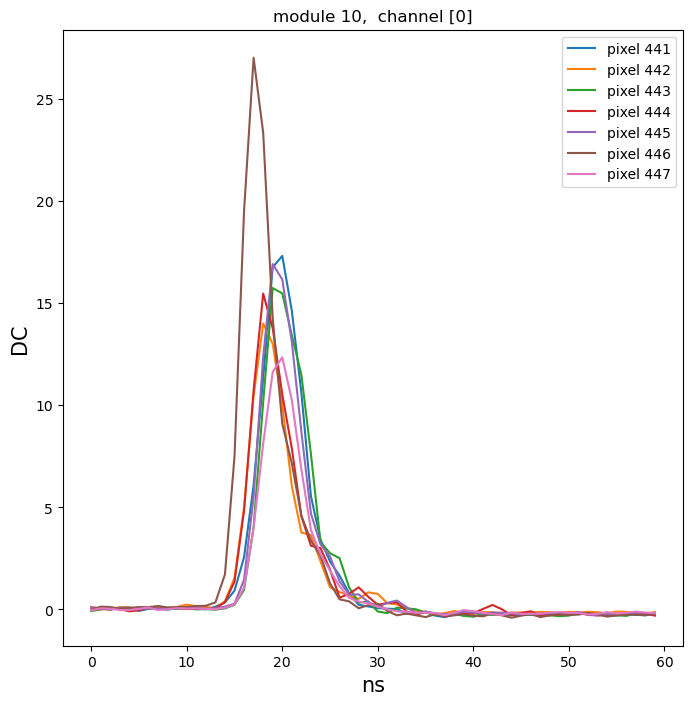

In [387]:
# plot R1 waveform of module [module]
mod = 1
tel_id = 0
module_id = event.nectarcam.tel[0].svc.module_ids[mod]


def view_waveform(chan=0, pix_id=6):
    waveform = event.r1.tel[tel_id].waveform
    plt.plot(waveform[chan, pix_id], label=f"pixel {pix_id}")

    plt.title(
        f"module {module_id},  channel {[chan]}",
    )
    max_now = waveform[chan, pix_id].max()
    min_now = waveform[chan, pix_id].min()

    plt.legend()
    plt.ylabel("DC", fontsize=15)
    plt.xlabel("ns", fontsize=15)


# module number

module = 63
module_rank = np.where(event.nectarcam.tel[0].svc.module_ids == module)

# ids of pixel in module
pixels_mod = event.nectarcam.tel[0].svc.pixel_ids[
    module_rank[0][0] * 7 : module_rank[0][0] * 7 + 7
]

# channel
chan = 0

fig = plt.figure(num=0, figsize=(8, 8))

for i, pix in enumerate(pixels_mod):
    view_waveform(chan=chan, pix_id=pix)

# plt.savefig(f"Run{run}_waveform_channel_{channel[chan]}_module_{module_id}.png")

In [58]:
# Comupte pedestals
waveform = event.r0.tel[0].waveform[1]
ped = np.mean(waveform[:, 20])

In [59]:
waveform

inf

In [202]:
window = 15
# wfs = []
wfs = event.r0.tel[0].waveform
ma.shape(wfs)

(2, 1855, 60)

In [388]:
ped_mean = np.mean(wfs[:, :, 0:window], axis=2)
ped_mean
ped_mean

/home/amikhno/local/opt/conda/envs/nectar-dev/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


array([[inf, inf, inf, ..., inf, inf, inf],
       [inf, inf, inf, ..., inf, inf, inf]], dtype=float32)

In [204]:
inf_mask = np.isinf(ped_mean)
inf_mask

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [206]:
ped_mean_expanded = ped_mean[:, :, None]  # Shape: (2, 1855, 1)
inf_mask_expanded = inf_mask[:, :, None]  # Shape: (2, 1855, 1)

# Perform subtraction and set wfs_pedsub to 0 where ped_mean is `inf`
wfs_pedsub = np.where(inf_mask_expanded, 0, wfs - ped_mean_expanded)

# Should be (2, 1855, 60)

(2, 1855, 60)


In [212]:
wfs_pedsub[:, :, 20]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [213]:
wfs_pedsub[0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [214]:
# integrate the charge on 12 ns around the peak value
from ctapipe_io_nectarcam import constants  # to get the constants

n_pixels = 1855
broken_pixel = np.zeros(n_pixels, dtype=bool)

config = Config({"LocalPeakWindowSum": {"window_shift": 4, "window_width": 10}})
integrator = LocalPeakWindowSum(source.subarray, config=config)


waveform = event.r1.tel[0].waveform

In [101]:
from ctapipe_io_nectarcam import constants

constants.HIGH_GAIN

import numpy as np

gain = constants.HIGH_GAIN

if gain == constants.HIGH_GAIN:
    selected_gain_channel = np.zeros(constants.N_PIXELS)
elif gain == constants.LOW_GAIN:
    selected_gain_channel = np.ones(constants.N_PIXELS)
else:
    print("something is wrong")
    selected_gain_channel = None

print(selected_gain_channel)
high_gain_channel = np.round(selected_gain_channel).astype(int)

[0. 0. 0. ... 0. 0. 0.]


In [102]:
gain_channels = np.stack((high_gain_channel, low_gain), axis=0)
gain_channels

array([[0, 0, 0, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 1]])

In [115]:
broken_pixels = np.stack((broken_pixel, broken_pixel), axis=0)
broken_pixels

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [124]:
waveforms = event.r1.tel[0].waveform[0, np.arange(n_pixels), :]
waveforms.shape

(1855, 60)

In [111]:
print(f"tel_id type: {type(tel_id)}")
print(f"gain_channels type: {type(gain_channels)}")
print(f"broken_pixel type: {type(broken_pixel)}")

tel_id type: <class 'int'>
gain_channels type: <class 'numpy.ndarray'>
broken_pixel type: <class 'numpy.ndarray'>


In [215]:
waveform = event.r0.tel[0].waveform
image = integrator(wfs_pedsub, 0, selected_gain_channel=0, broken_pixels=broken_pixels)

In [216]:
image

ctapipe.containers.DL1CameraContainer:
                         image: Numpy array of camera image, after waveform
                                extraction.Shape: (n_pixel) with default None as
                                a 1-D array with dtype float32
                     peak_time: Numpy array containing position of the peak of
                                the pulse as determined by the extractor. Shape:
                                (n_pixel, ) with default None as a 1-D array
                                with dtype float32
                    image_mask: Boolean numpy array where True means the pixel
                                has passed cleaning. Shape: (n_pixel, ) with
                                default None as a 1-D array with dtype bool
                      is_valid: True if image extraction succeeded, False if
                                failed or in the case of TwoPass methods, that
                                the first pass only was returned.

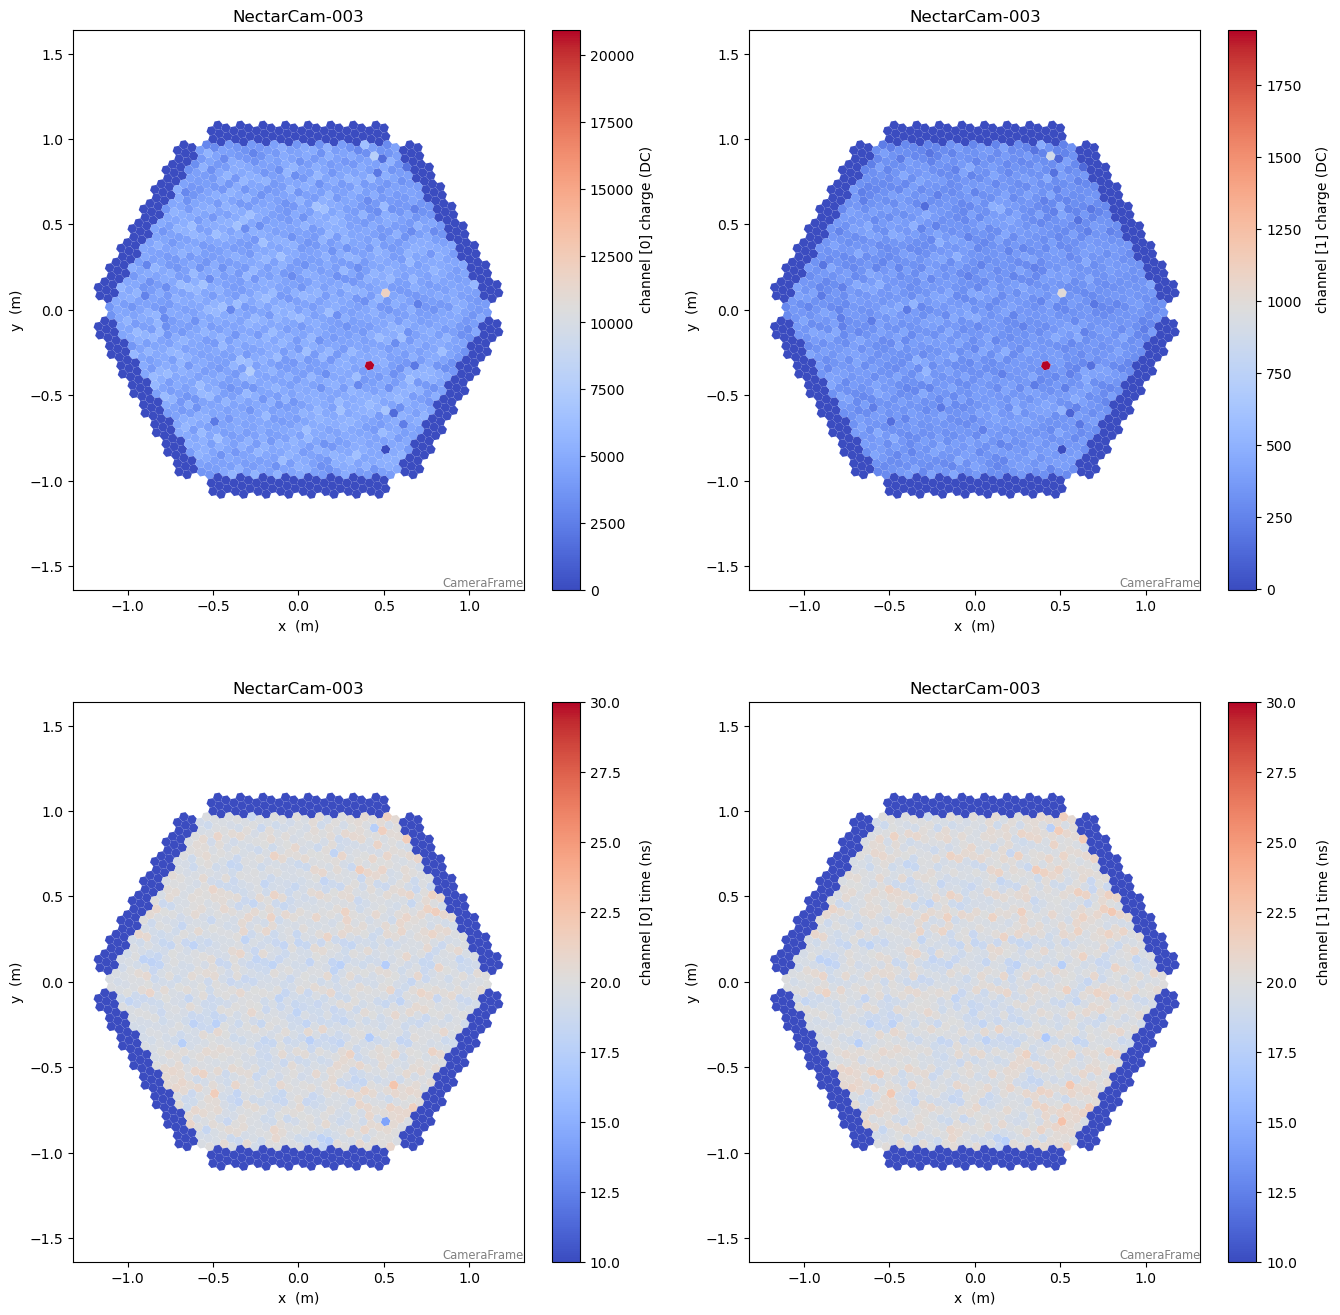

In [217]:
fig = plt.figure(figsize=(16, 16))
for chan in np.arange(2):
    ax = plt.subplot(2, 2, chan + 1)

    disp = CameraDisplay(source.subarray.tel[0].camera.geometry)
    disp.image = image.image[chan]

    # disp.set_limits_minmax(2000,4000)
    disp.cmap = plt.cm.coolwarm
    disp.axes.text(2.0, 0, f"channel {[chan]} charge (DC)", fontsize=10, rotation=90)
    disp.add_colorbar()

    ax = plt.subplot(2, 2, chan + 3)
    disp = CameraDisplay(source.subarray.tel[0].camera.geometry)
    disp.image = image.peak_time[chan]
    disp.cmap = plt.cm.coolwarm
    disp.set_limits_minmax(10, 30)
    disp.axes.text(2.0, 0, f"channel {[chan]} time (ns)", fontsize=10, rotation=90)

    disp.add_colorbar()

    disp.update()

# plt.savefig(f"Run{run}_event_{event.nectarcam.tel[0].evt.event_id}_charge_time.png")

In [218]:
image.image

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [219]:
mod = 1
event.nectarcam.tel[0].svc.pixel_ids[mod * 7 : mod * 7 + 7]

array([70, 71, 72, 73, 74, 75, 76], dtype=uint16)

In [220]:
image.peak_time[0, 70] - integrator.window_shift.tel[0]

16.457469940185547

In [221]:
int(max(image.peak_time[chan, pix] - integrator.window_shift.tel[0], 0))

15

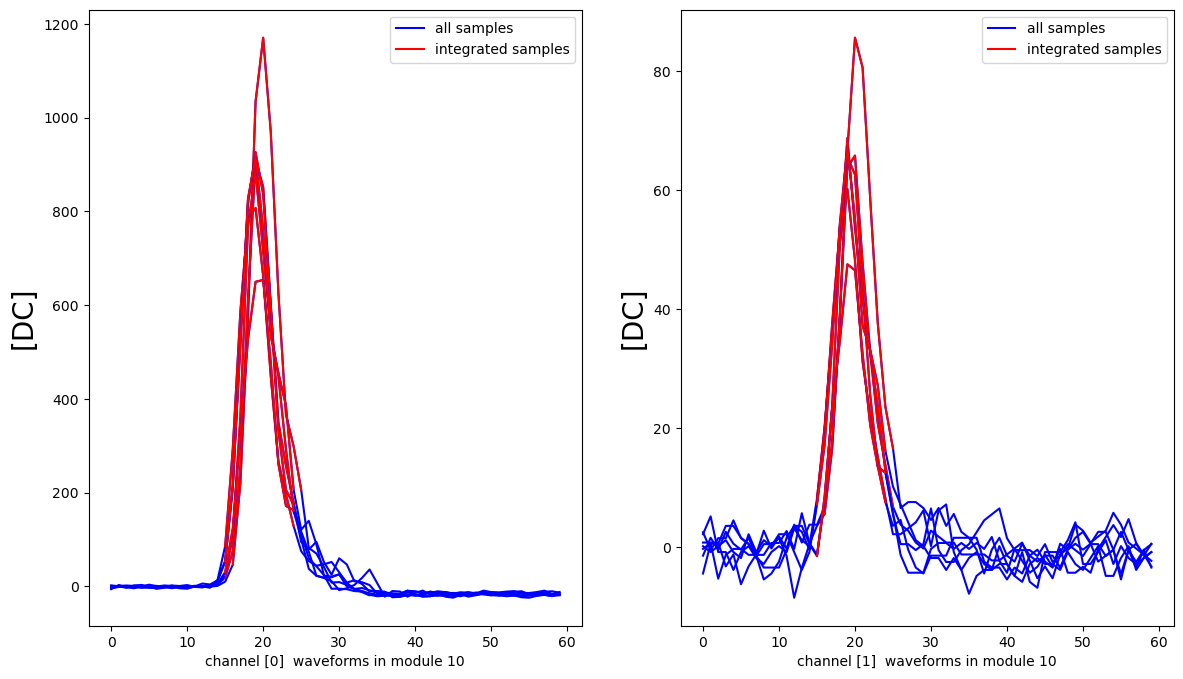

In [391]:
# Plot the part of the waveform that is integrated
# (this work only after the line above)

fig = plt.figure(0, figsize=(14, 8))

# consider only 36 samples
samples = np.arange(0, 60)

# chose the module
mod = 1
module_id = event.nectarcam.tel[0].svc.module_ids[mod]
# find pixel index in module
pix_in_mod = event.nectarcam.tel[0].svc.pixel_ids[mod * 7 : mod * 7 + 7]

for chan in np.arange(2):
    plt.subplot(1, 2, chan + 1)

    for i, pix in enumerate(pix_in_mod):
        # samples used to calculate the charge
        start = int(max(image.peak_time[chan, pix] - integrator.window_shift.tel[0], 0))
        stop = int(min(start + integrator.window_width.tel[0], 60))
        used_samples = np.arange(start, stop)
        used = wfs_pedsub[chan, pix, start:stop]

        plt.plot(
            wfs_pedsub[
                chan,
                pix,
            ],
            color="b",
            label="all samples",
        )
        plt.plot(used_samples, used, color="r", label="integrated samples")

        if i == 0:
            plt.legend()

        # plt.ylim(-150,300)
        plt.ylabel("[DC]", fontsize=20)
        plt.xlabel(f"channel {[chan]}  waveforms in module {module_id}", fontsize=10)
        # plt.ylim(-50,4000)
        # plt.legend()
        fig.savefig(f"Run{run}_waverforms_module_zoom_{module_id}.png")

        # fig.savefig(f"Run{run}_event_75_all.png")

In [239]:
signal_mean = np.mean(image.image[:], axis=-1)
signal_var = np.var(image.image[:], axis=-1)

In [348]:
signal_var, signal_mean
gain = signal_mean / signal_var
gain

array([0.00100104, 0.01299315], dtype=float32)

In [349]:
pixel_spec_signal = image.image[:] / (np.expand_dims(gain[:], axis=-1))
pixel_spec_signal

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [350]:
mean_camera_signal = np.expand_dims((signal_mean[:] / gain[:]), axis=-1)
mean_camera_signal

array([[3800805.8  ],
       [  21541.848]], dtype=float32)

In [351]:
# Ralative efficience

eff = pixel_spec_signal[:] / mean_camera_signal[:]
eff

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [352]:
ff = np.divide(1, eff, out=np.zeros_like(eff, dtype=float), where=eff != 0)
ff

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

1260.0550537109375

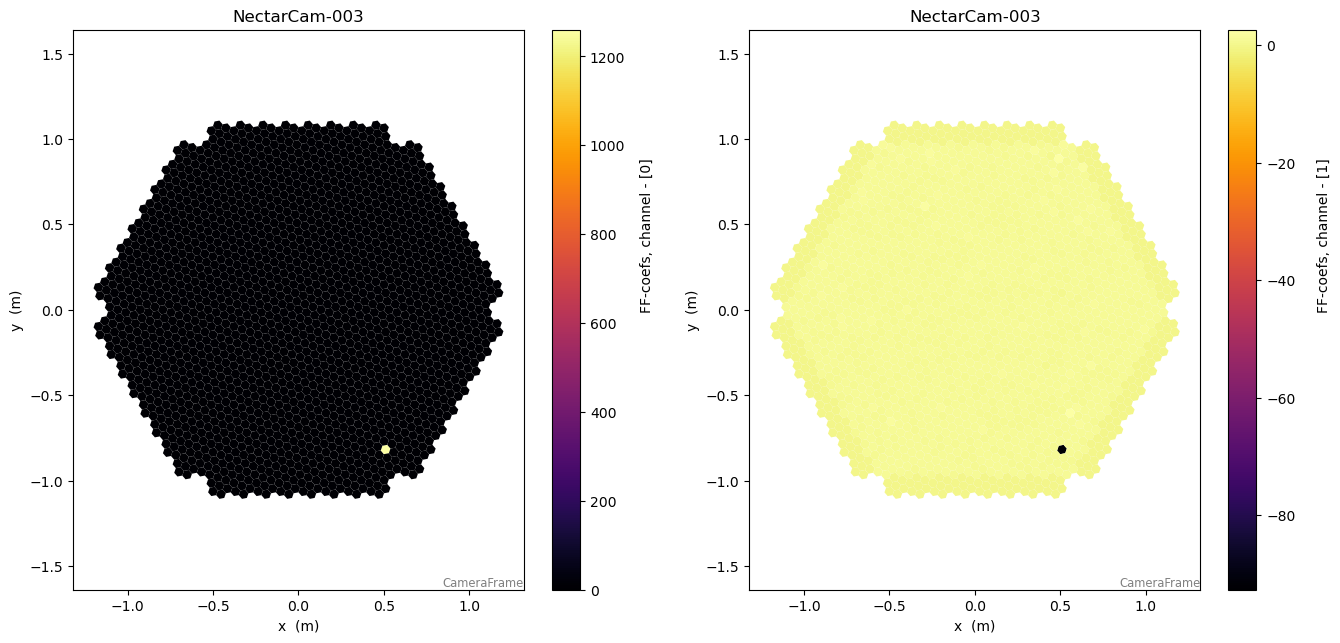

In [353]:
fig = plt.figure(figsize=(16, 16))
for chan in np.arange(2):
    ax = plt.subplot(2, 2, chan + 1)

    disp = CameraDisplay(source.subarray.tel[0].camera.geometry)
    disp.image = ff[chan]

    # disp.set_limits_minmax(2000,4000)
    # disp.cmap = plt.cm.coolwarm
    disp.axes.text(2.0, 0, f"FF-coefs, channel - {[chan]}", fontsize=10, rotation=90)

    disp.add_colorbar()

    disp.update()

In [354]:
# Illuminating a weird pixel

ff_new = ff.copy()
ff_new[0, 1702] = 0
ff_new[1, 1702] = 0

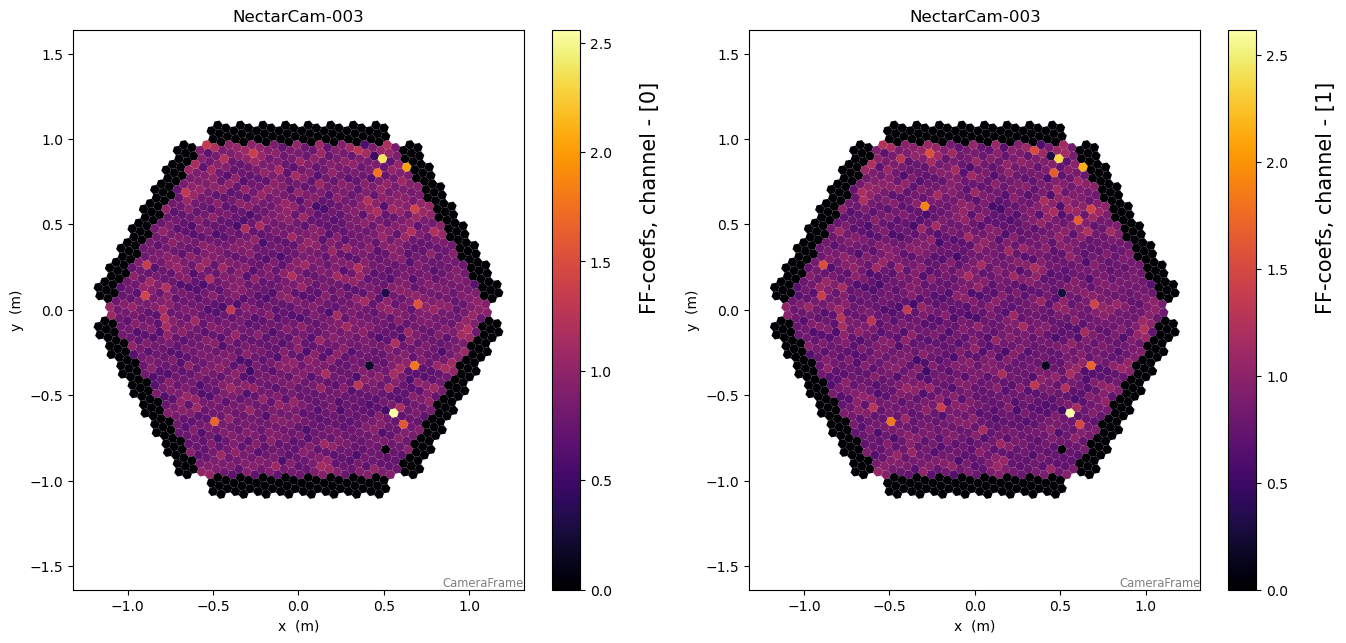

In [355]:
fig = plt.figure(figsize=(16, 16))
for chan in np.arange(2):
    ax = plt.subplot(2, 2, chan + 1)

    disp = CameraDisplay(source.subarray.tel[0].camera.geometry)
    disp.image = ff_new[chan]

    # disp.set_limits_minmax(2000,4000)
    # disp.cmap = plt.cm.coolwarm
    disp.axes.text(2.0, 0, f"FF-coefs, channel - {[chan]}", fontsize=15, rotation=90)

    disp.add_colorbar()

    disp.update()

In [358]:
# To take into account wavefront shape

pixel_x = source.subarray.tel[0].camera.geometry.pix_x
pixel_y = source.subarray.tel[0].camera.geometry.pix_y

# Flasher center (x0, y0)
x0, y0 = 0.0, 0.0  # Adjust based on your flasher's location

# Compute distances from flasher center
distances = np.sqrt((pixel_x - x0) ** 2 + (pixel_y - y0) ** 2).value
distances

array([1.08166538, 1.09658561, 1.14564392, ..., 1.08166538, 1.09658561,
       1.14564392])

In [383]:
sigma = 8.0  # TO BE CHECKED
amplitude = 2.0  # normalize later

# Gaussian intensity
intensity = amplitude * np.exp(-(distances**2) / (2 * sigma**2))
expected_response = intensity / np.sum(intensity)

In [360]:
# Apply
pixel_spec_signal = image.image[:] / (
    np.expand_dims(gain[:], axis=-1) * expected_response
)
eff = pixel_spec_signal[:] / mean_camera_signal[:]
ff_gaus = np.divide(1, eff, out=np.zeros_like(eff, dtype=float), where=eff != 0)

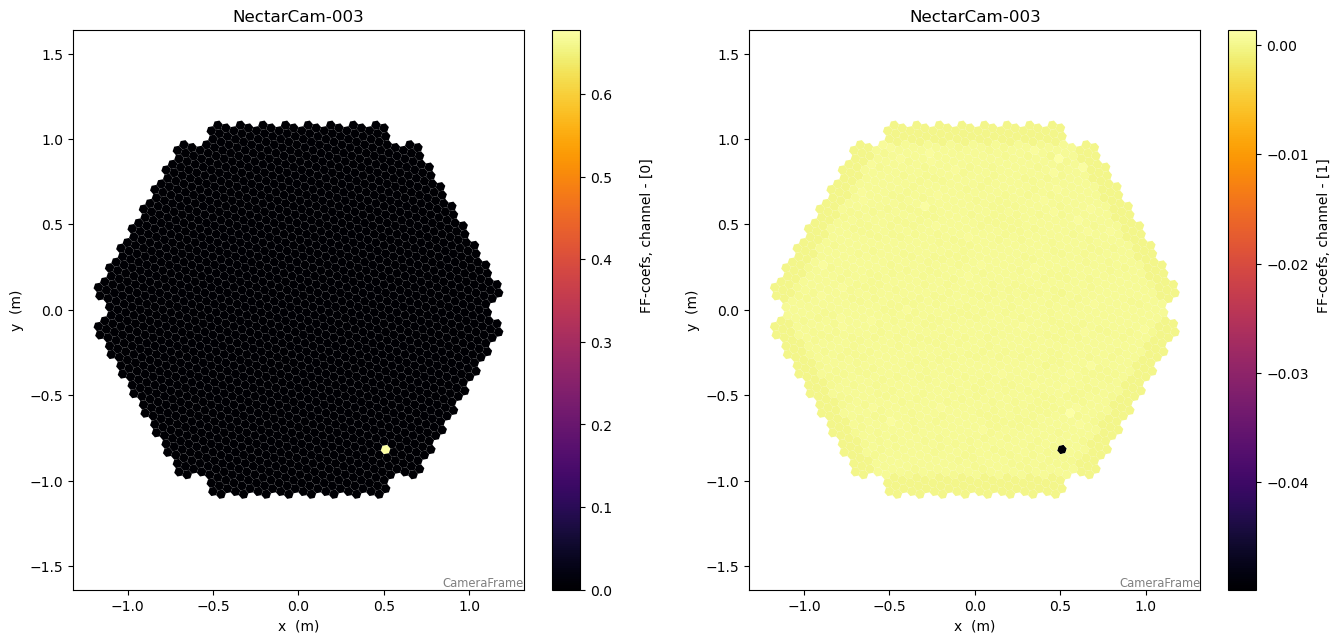

In [361]:
fig = plt.figure(figsize=(16, 16))
for chan in np.arange(2):
    ax = plt.subplot(2, 2, chan + 1)

    disp = CameraDisplay(source.subarray.tel[0].camera.geometry)
    disp.image = ff_gaus[chan]

    # disp.set_limits_minmax(2000,4000)
    # disp.cmap = plt.cm.coolwarm
    disp.axes.text(2.0, 0, f"FF-coefs, channel - {[chan]}", fontsize=10, rotation=90)

    disp.add_colorbar()

    disp.update()

In [362]:
ff_gaus_new = ff_gaus.copy()
ff_gaus_new[0, 1702] = 0
ff_gaus_new[1, 1702] = 0

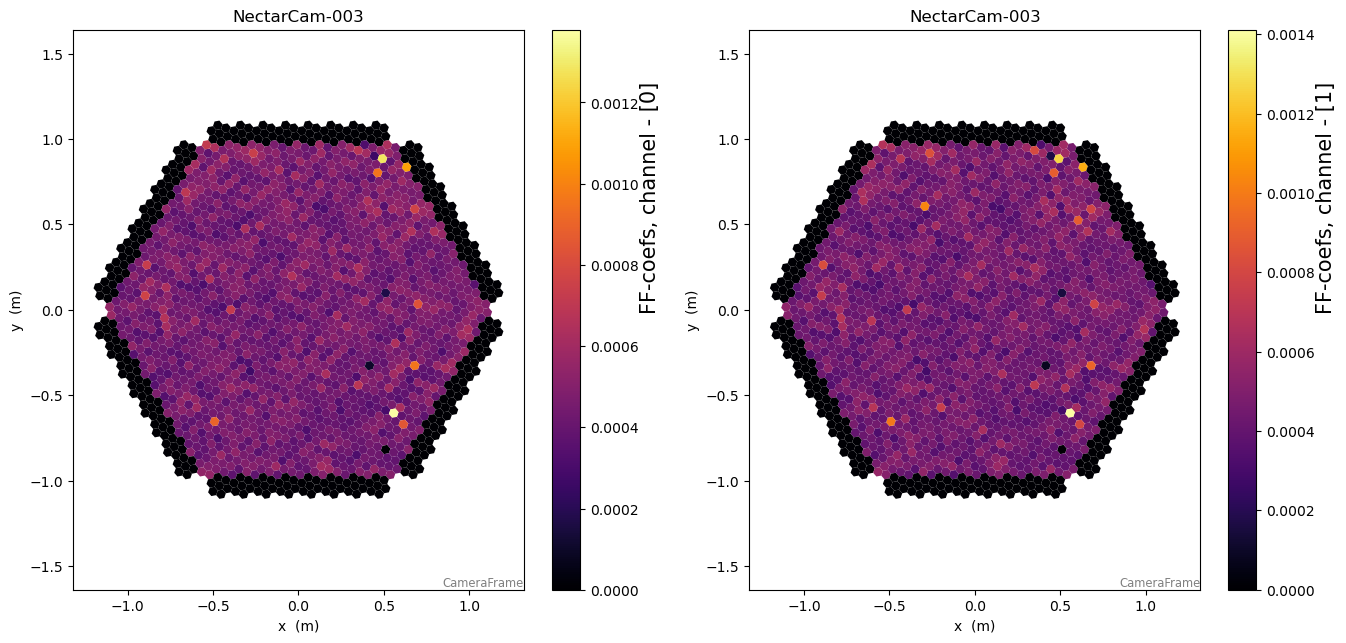

In [363]:
fig = plt.figure(figsize=(16, 16))
for chan in np.arange(2):
    ax = plt.subplot(2, 2, chan + 1)

    disp = CameraDisplay(source.subarray.tel[0].camera.geometry)
    disp.image = ff_gaus_new[chan]

    # disp.set_limits_minmax(2000,4000)
    # disp.cmap = plt.cm.coolwarm
    disp.axes.text(2.0, 0, f"FF-coefs, channel - {[chan]}", fontsize=15, rotation=90)

    disp.add_colorbar()

    disp.update()

In [384]:
image.image[:, 1702] = [0, 0]
signal_mean = np.mean(image.image[:], axis=-1)
signal_var = np.var(image.image[:], axis=-1)
gain = signal_mean / signal_var
print(gain)

pixel_spec_signal = image.image[:] / (np.expand_dims(gain[:], axis=-1))
mean_camera_signal = np.expand_dims((signal_mean[:] / gain[:]), axis=-1)
eff = pixel_spec_signal[:] / mean_camera_signal[:]
ff_test = np.divide(
    1, eff * expected_response, out=np.zeros_like(eff, dtype=float), where=eff != 0
)

[0.00100104 0.01299378]


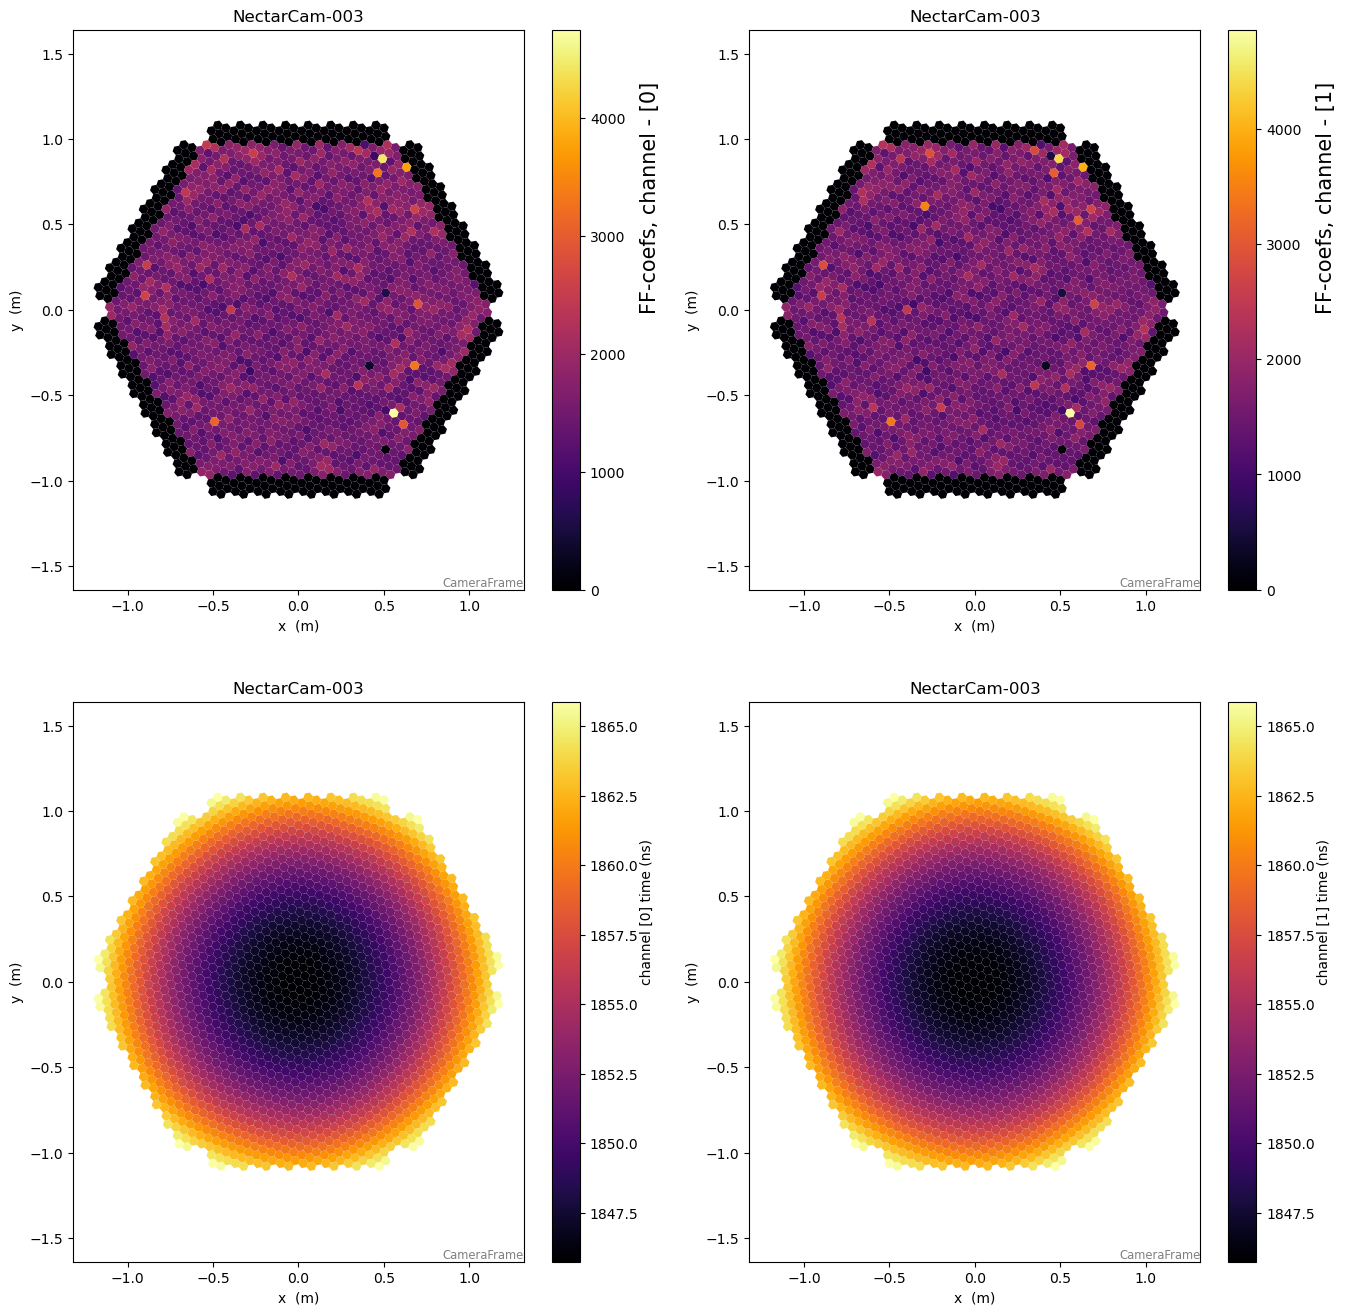

In [385]:
fig = plt.figure(figsize=(16, 16))
for chan in np.arange(2):
    ax = plt.subplot(2, 2, chan + 1)

    disp = CameraDisplay(source.subarray.tel[0].camera.geometry)
    disp.image = ff_test[chan]

    # disp.set_limits_minmax(2000,4000)
    # disp.cmap = plt.cm.coolwarm
    disp.axes.text(2.0, 0, f"FF-coefs, channel - {[chan]}", fontsize=15, rotation=90)

    disp.add_colorbar()

    ax = plt.subplot(2, 2, chan + 3)
    disp = CameraDisplay(source.subarray.tel[0].camera.geometry)

    disp.image = 1 / expected_response
    # disp.image = 1/expected_response

    disp.axes.text(2.0, 0, f"channel {[chan]} time (ns)", fontsize=10, rotation=90)

    disp.add_colorbar()

    disp.update()

array([0., 0.], dtype=float32)

In [ ]:
# use the tool to write calibration coefficients
# you can call it also as "python write_camera_calibration.py --help"

from nectarchain.tools.write_camera_calibration import CalibrationHDF5Writer

calibration_tool = CalibrationHDF5Writer()

In [175]:
calibration_tool.run()

2025-01-27 13:06:45,884 INFO [nectarchain.CalibrationHDF5Writer] ((unknown file).(unknown function)): Starting: CalibrationHDF5Writer
--- Logging error ---
Traceback (most recent call last):
  File "/home/amikhno/local/opt/conda/envs/nectar-dev/lib/python3.11/logging/__init__.py", line 1110, in emit
    msg = self.format(record)
          ^^^^^^^^^^^^^^^^^^^
  File "/home/amikhno/local/opt/conda/envs/nectar-dev/lib/python3.11/logging/__init__.py", line 953, in format
    return fmt.format(record)
           ^^^^^^^^^^^^^^^^^^
  File "/home/amikhno/local/opt/conda/envs/nectar-dev/lib/python3.11/site-packages/ctapipe/core/logging.py", line 22, in format
    return s.replace(record.levelname, apply_colors(record.levelname))
                                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/amikhno/local/opt/conda/envs/nectar-dev/lib/python3.11/site-packages/ctapipe/core/logging.py", line 38, in apply_colors
    levelname_color = color_seq % (30 + colors[levelname]) + leve

SystemExit: 1

/home/amikhno/local/opt/conda/envs/nectar-dev/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [177]:
# read back the monitoring containers written with the tool write_camera_calibration.py
from ctapipe.containers import FlatFieldContainer, WaveformCalibrationContainer
from ctapipe.io.hdf5tableio import HDF5TableWriter, HDF5TableReader

ff_data = FlatFieldContainer()
cal_data = WaveformCalibrationContainer()

with HDF5TableReader("calibration.hdf5") as h5_table:
    assert h5_table._h5file.isopen == True

    for cont in h5_table.read("/tel_0/flatfield", ff_data):
        print(cont.as_dict())

    for cont in h5_table.read("/tel_0/calibration", cal_data):
        print(cont.as_dict())

        break

h5_table.close()

chan = 0
values = 1 / cont.dc_to_pe[chan]
# Perform some plots
fig = plt.figure(13, figsize=(16, 5))
disp = CameraDisplay(camera)
disp.image = values
# disp.set_limits_minmax(0,1)
disp.cmap = plt.cm.coolwarm
disp.axes.text(2.4, 0, "photon electrons", rotation=90)
disp.add_colorbar()

#
select = np.logical_not(cont.unusable_pixels[0])


fig = plt.figure(12, figsize=(16, 5))
plt.hist(values[select], color="r", histtype="step", bins=50, stacked=True, fill=False)
plt.title(f"ADC per photon-electrons, mean={np.mean(values[select]):5.0f} ADC")

FileNotFoundError: ``/home/amikhno/PycharmProjects/pythonProject1/calibration.hdf5`` does not exist